In [108]:
import time
from datetime import datetime
import vectorbt as vbt
from tqdm import tqdm

import pandas as pd
import pandas_ta as ta
import numpy as np
import mplfinance as mpf

from scipy.signal import argrelextrema
import matplotlib.pyplot as plt

### Choppiness Index

##### ส่วนประกอบ indicator
- ตั้งค่าเริ่มตัน length = 14
- มีค่า 0 - 100
- ถ้าค่าเข้าใกล้หรือมากกว่า 61.8 หมายถึงราคาไม่เป็นเทรนหรือ sideway
- ถ้าค่าเข้าใกล้หรือน้อยกว่า 38.2 หมายถึงกราฟมีเทรน

##### ตัวอย่างใช้งาน
- ดูกราฟว่าเป็นเทรนหรือ sideway
- หาจุดเข้าเมื่อค่าน้อยกว่า 38.2
- ใช้เป็นจุดเฝ้าระวังเมื่อค่ามากกว่า 61.8
- กราฟขึ้นจาก 50 ไป 61.8 มักเป็น sideway
- กราฟลงจาก 61.8 มักเป็นจุด break out
- กราฟลงจาก 50 ไป 38.2 น่าเป็นจุดเข้าเทรด
- กราฟขึ้นจาก 38.2 น่าเป็นจุดออก

##### ที่มา
- https://www.incrediblecharts.com/indicators/choppiness-index.php
- https://phemex.com/academy/what-is-choppiness-index
- https://optionstradingiq.com/choppiness-index/
- https://www.tradingsim.com/day-trading/choppiness-index-indicator
- https://medium.com/coinmonks/the-choppiness-index-detecting-trends-sideways-a-study-in-python-2a367eba17f5

In [130]:
data = pd.read_csv('../MyStrategy/GBPUSD_1h.csv')
data.tail()

,timestamp,open,high,low,close,adj close,volumn
5011,2022-08-30 13:00:00+01:00,1.171921,1.172044,1.169098,1.170029,1.170029,0
5012,2022-08-30 14:00:00+01:00,1.169892,1.171921,1.169180,1.169905,1.169905,0
5013,2022-08-30 15:00:00+01:00,1.168484,1.168484,1.162372,1.162926,1.162926,0
5014,2022-08-30 16:00:00+01:00,1.163399,1.167174,1.163399,1.165189,1.165189,0
5015,2022-08-30 17:00:00+01:00,1.165365,1.166521,1.164985,1.165189,1.165189,0


In [131]:
df = data.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True).dt.tz_localize(None)
df.set_index('timestamp', inplace = True)
df

,open,high,low,close,adj close,volumn
timestamp,,,,,,
2021-11-04 17:00:00,1.349364,1.349437,1.348418,1.349273,1.349273,0
2021-11-04 18:00:00,1.349382,1.350366,1.349091,1.349655,1.349655,0
2021-11-04 19:00:00,1.349509,1.350475,1.349509,1.350238,1.350238,0
2021-11-04 20:00:00,1.350311,1.350457,1.349509,1.350020,1.350020,0
2021-11-04 21:00:00,1.349692,1.350202,1.348745,1.350074,1.350074,0
...,...,...,...,...,...,...
2022-08-30 12:00:00,1.171921,1.172044,1.169098,1.170029,1.170029,0
2022-08-30 13:00:00,1.169892,1.171921,1.169180,1.169905,1.169905,0
2022-08-30 14:00:00,1.168484,1.168484,1.162372,1.162926,1.162926,0


In [4]:
def chop_plot(df, start, end, chop_length):
    df_plot = df.iloc[start: end]
    chop = df_plot['CHOP_'+str(chop_length)+'_1_100']

    fibo_above = np.empty(df_plot.shape[0])
    fibo_above.fill(61.8)
    fibo_below = np.empty(df_plot.shape[0])
    fibo_below.fill(38.2)

    chop_plot = mpf.make_addplot(chop, panel=1, color='blue', width=1, ylabel='chop')
    fibo_above_plot = mpf.make_addplot(fibo_above, panel=1, color='orange', width=0.8)
    fibo_below_plot = mpf.make_addplot(fibo_below, panel=1, color='orange', width=0.8)

    up_markers = []
    down_markers = []
    result_plots = [chop_plot, fibo_above_plot, fibo_below_plot]

    up_not_nan = False
    dow_not_nan = False
    for index, row in df_plot.iterrows():
        if row['chop_below38'] == True:
            up_markers.append(row['low'] * 0.998)
            down_markers.append(np.nan)
            up_not_nan = True
        elif row['chop_above61'] == True:
            up_markers.append(np.nan)
            down_markers.append(row['high'] * 1.002)
            dow_not_nan = True
        else:
            up_markers.append(np.nan)
            down_markers.append(np.nan)
    
    if up_not_nan == True : 
        up_plot = mpf.make_addplot(up_markers, type='scatter', marker='^', markersize=10, panel=0, color='red')
        result_plots.append(up_plot)
    if dow_not_nan == True : 
        down_plot = mpf.make_addplot(down_markers, type='scatter', marker='v', markersize=10, panel=0, color='green')
        result_plots.append(down_plot)

    return result_plots

In [5]:
df.ta.chop(14, append=True)
df['prev_chop'] = df['CHOP_14_1_100'].shift(1)
df['chop_above61'] = (df['prev_chop'] < 61.8) & (df['CHOP_14_1_100'] >= 61.8)
df['chop_below38'] = (df['prev_chop'] > 38.2) & (df['CHOP_14_1_100'] <= 38.2)
df

,open,high,low,close,adj close,volumn,CHOP_14_1_100,prev_chop,chop_above61,chop_below38
timestamp,,,,,,,,,,
2021-11-04 17:00:00,1.349364,1.349437,1.348418,1.349273,1.349273,0,NaN,NaN,False,False
2021-11-04 18:00:00,1.349382,1.350366,1.349091,1.349655,1.349655,0,NaN,NaN,False,False
2021-11-04 19:00:00,1.349509,1.350475,1.349509,1.350238,1.350238,0,NaN,NaN,False,False
2021-11-04 20:00:00,1.350311,1.350457,1.349509,1.350020,1.350020,0,NaN,NaN,False,False
2021-11-04 21:00:00,1.349692,1.350202,1.348745,1.350074,1.350074,0,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...
2022-08-30 12:00:00,1.171921,1.172044,1.169098,1.170029,1.170029,0,54.761033,52.020351,False,False
2022-08-30 13:00:00,1.169892,1.171921,1.169180,1.169905,1.169905,0,55.549325,54.761033,False,False
2022-08-30 14:00:00,1.168484,1.168484,1.162372,1.162926,1.162926,0,37.924417,55.549325,False,True


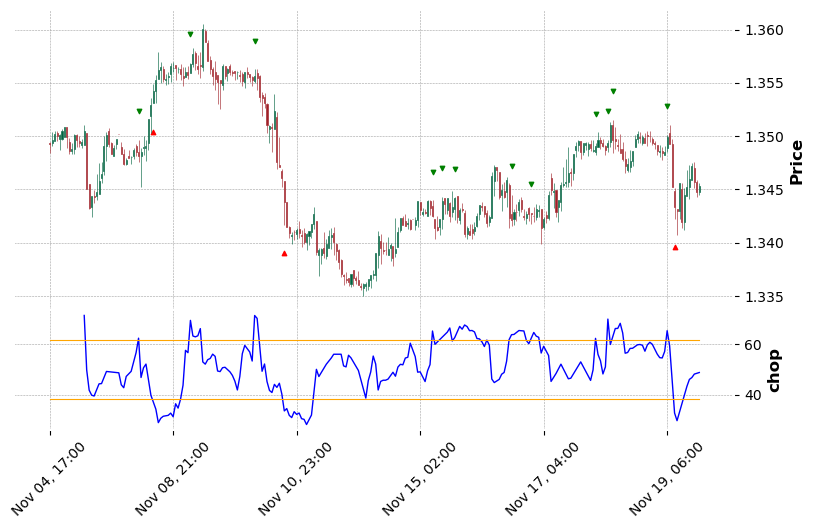

In [6]:
chop_info_plots = chop_plot(df, 0, 264, 14)

mpf.plot(df.iloc[0:264], type='candle', style='charles',
         addplot=chop_info_plots,
         figsize=(10, 6))

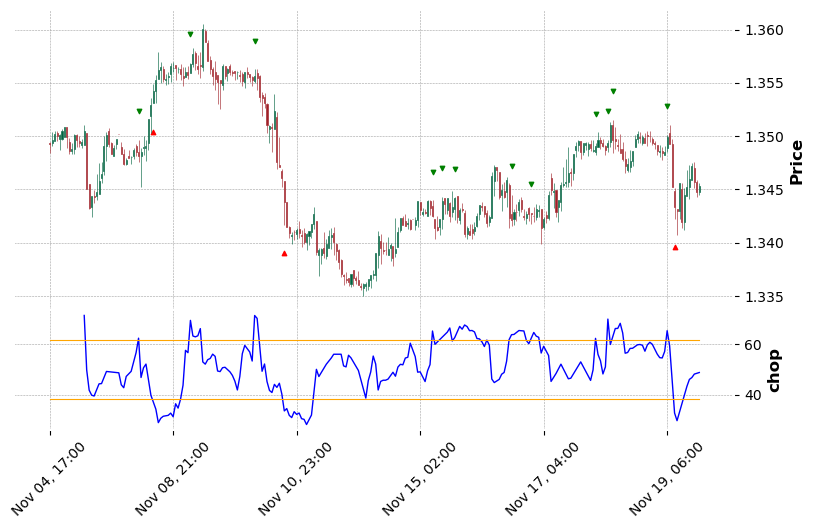

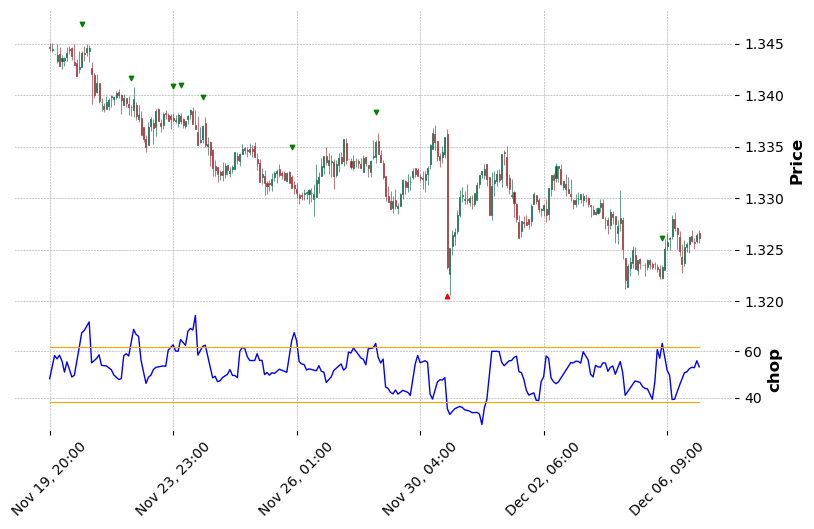

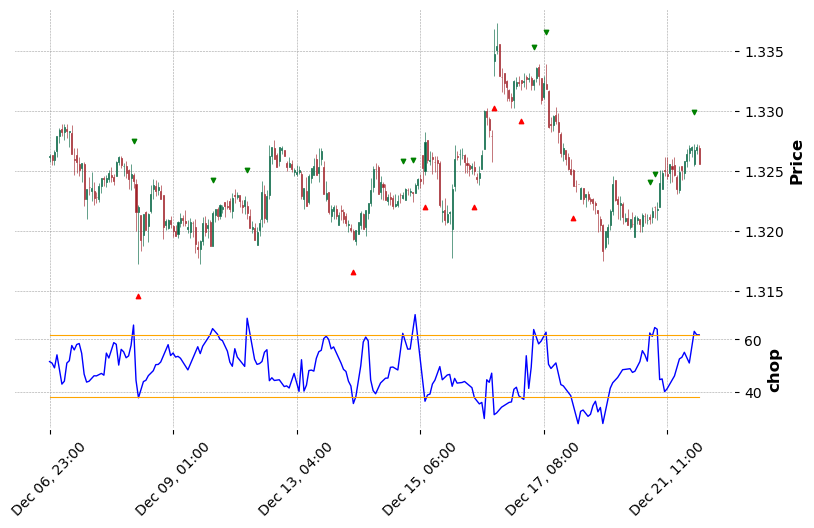

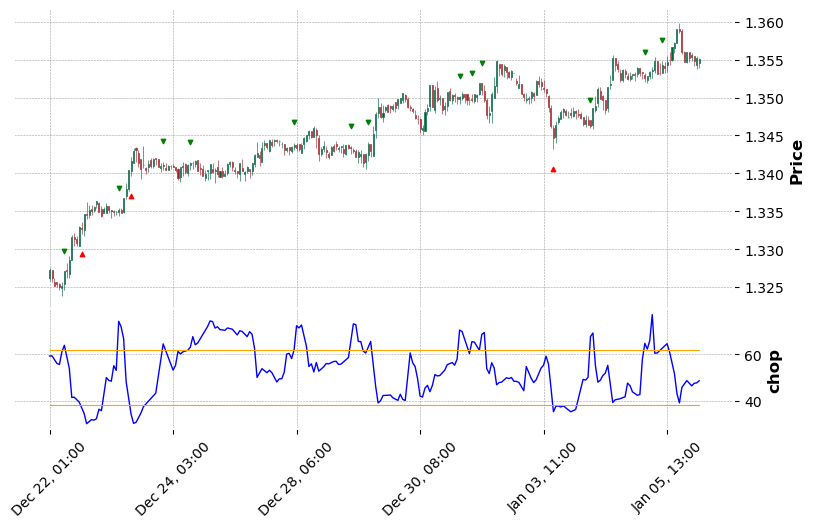

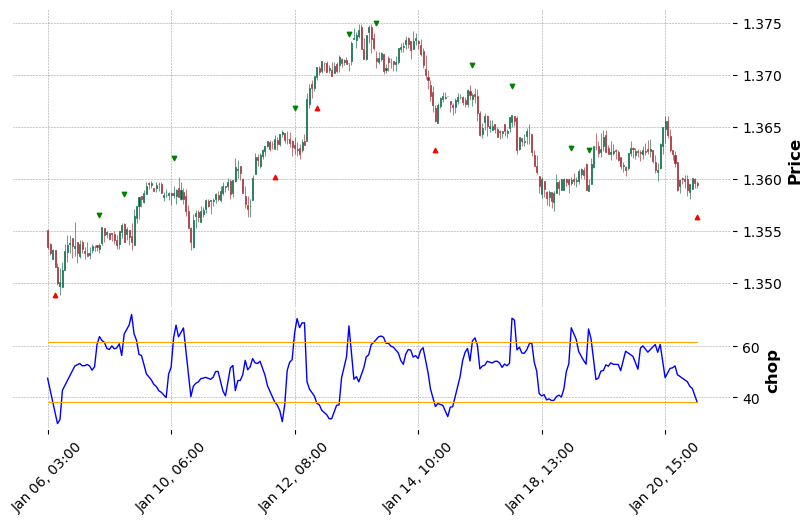

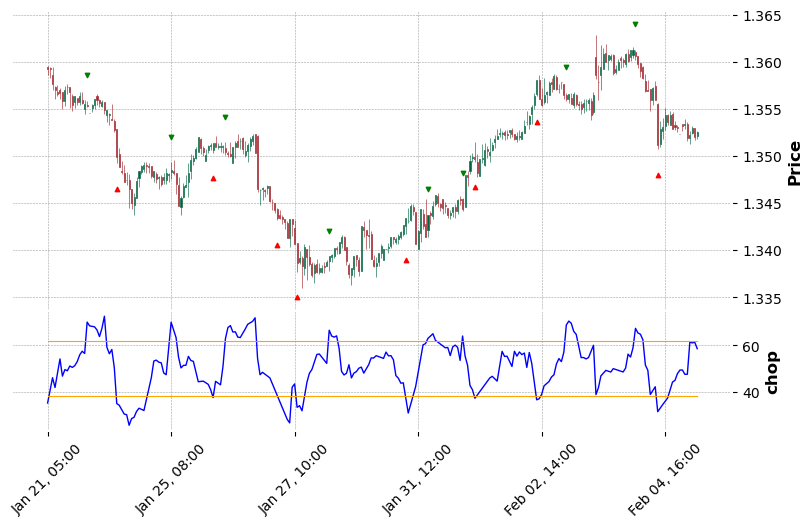

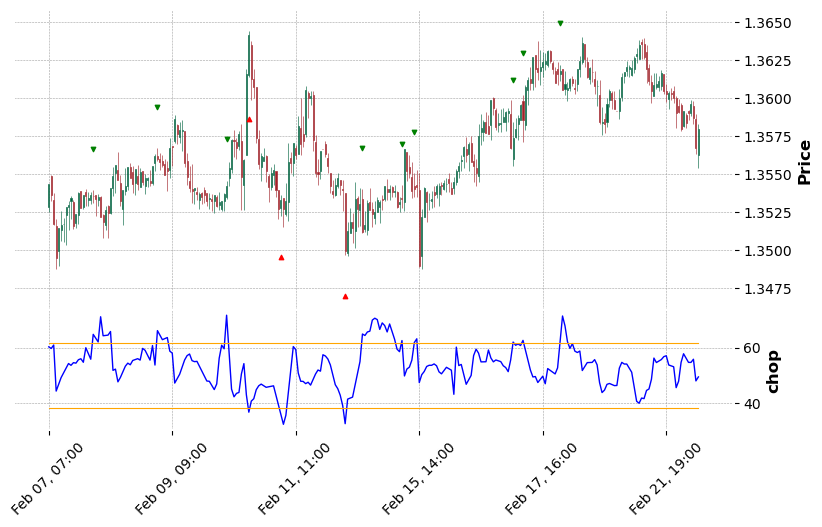

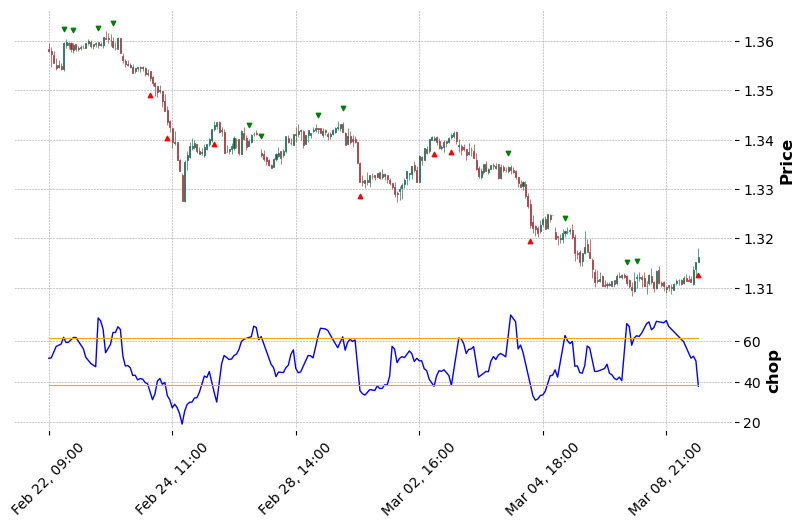

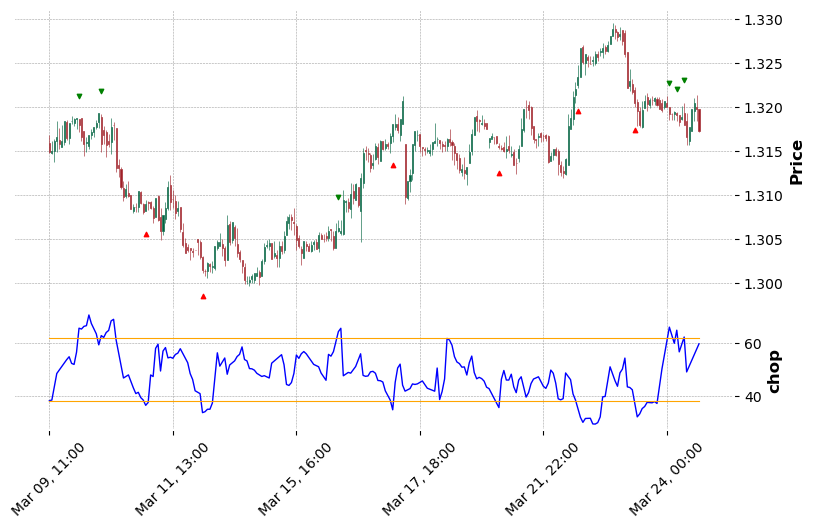

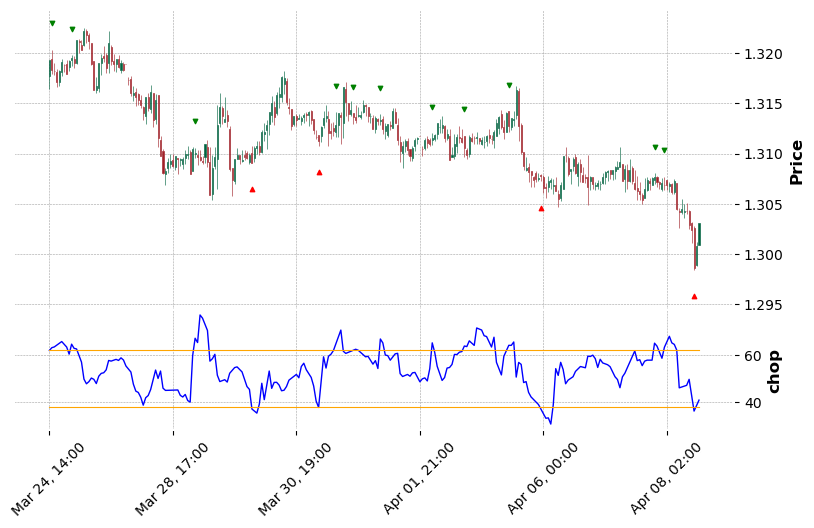

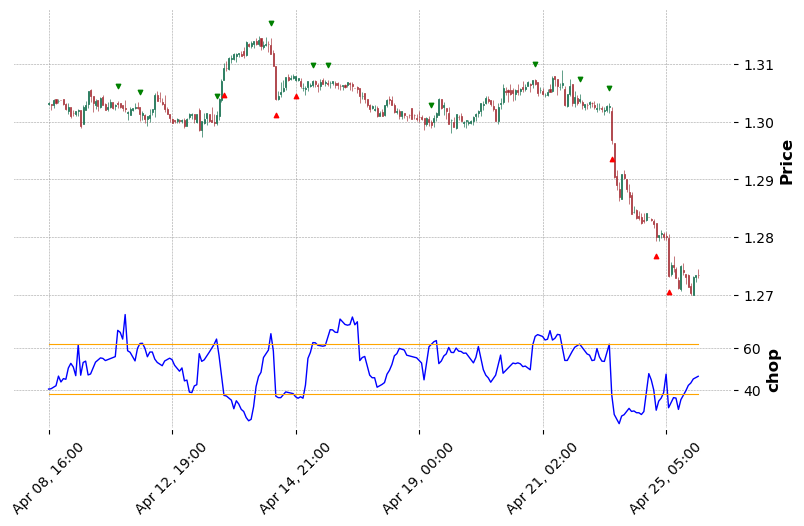

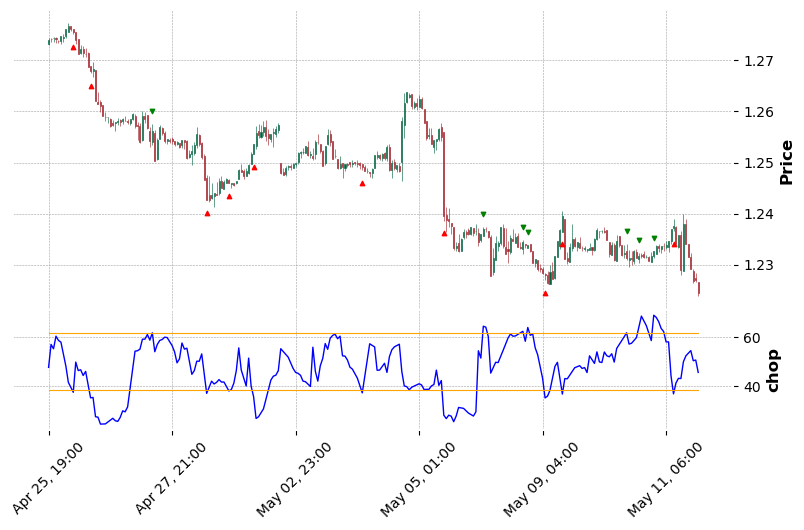

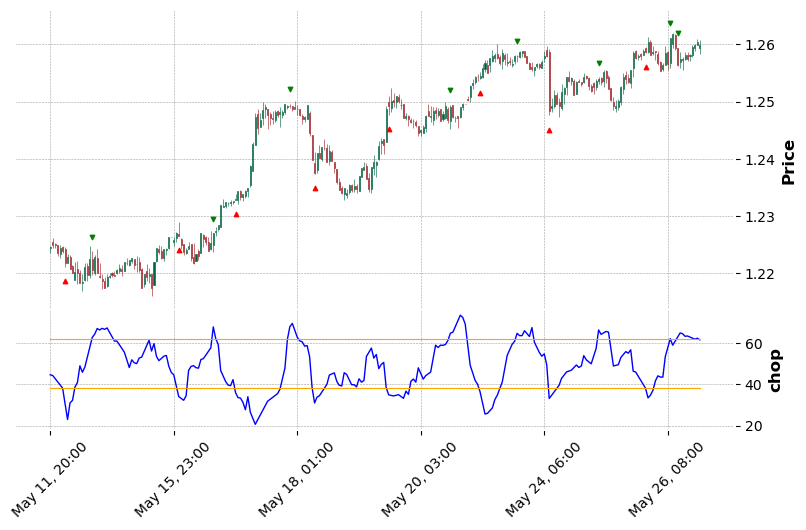

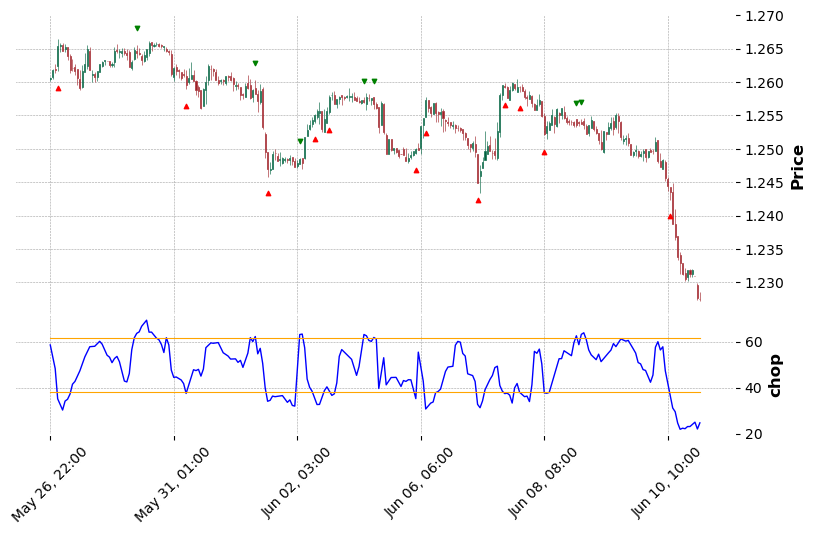

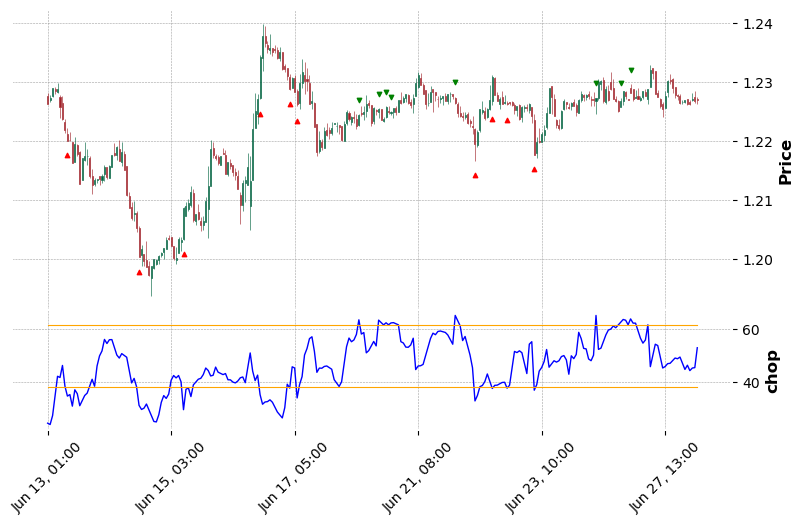

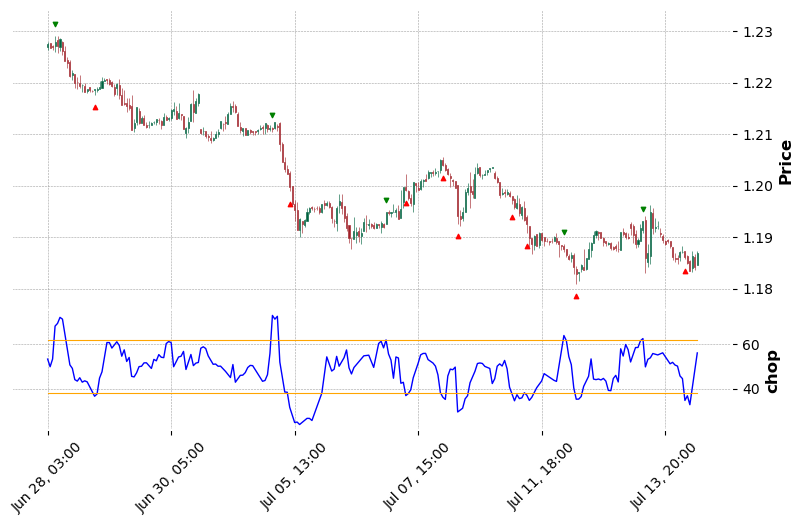

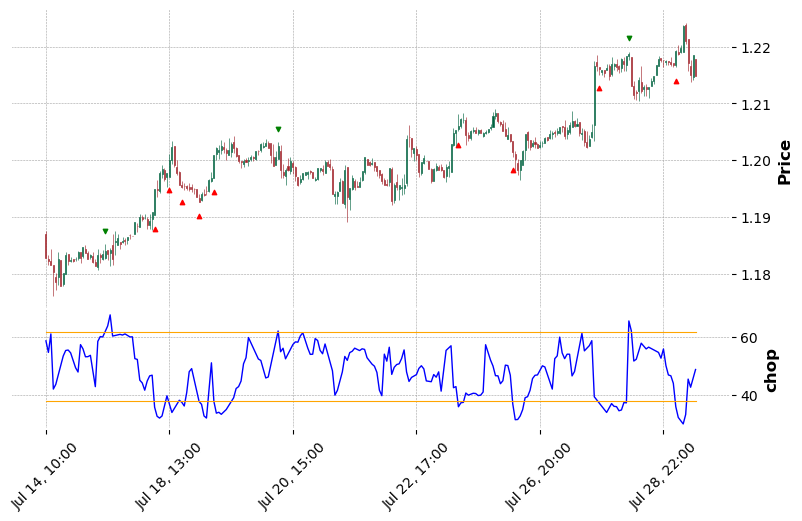

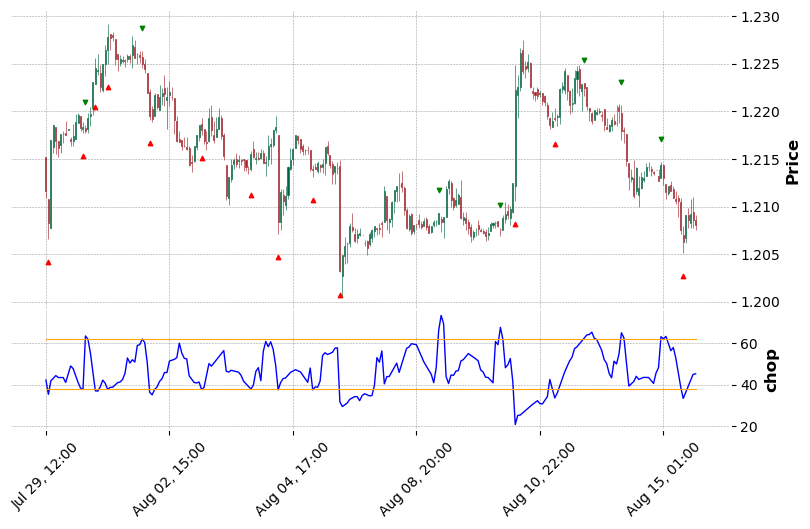

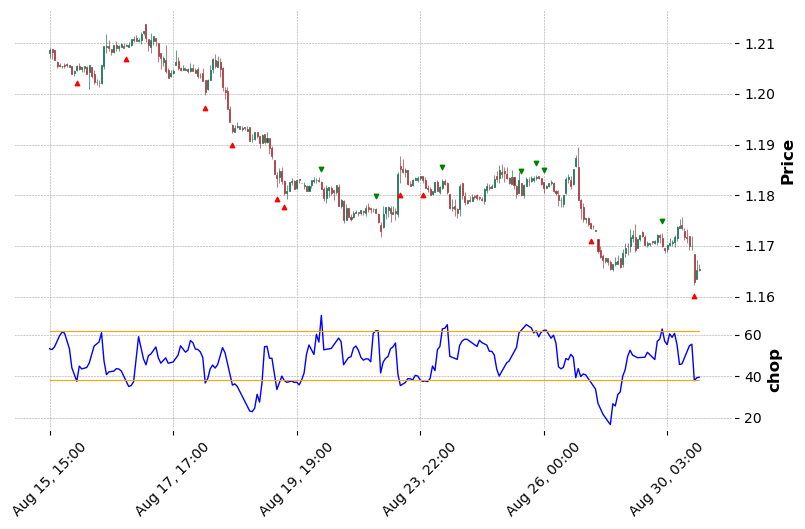

In [8]:
df_windows = np.linspace( 0, len(df), 20 )

for i in range(len(df_windows) - 1):
    start, end = int(df_windows[i]), int(df_windows[i+1])
    stoch_info_plots = chop_plot(df, start, end, 14)

    mpf.plot(df.iloc[start:end], type='candle', style='charles',
         addplot=stoch_info_plots,
         figsize=(10, 6))

In [53]:
def find_peak(price, i, order):
    # max_idx, min_idx ใช้หาจุดสูงสุด/ต่ำสุดสัมพัทธ์ทั้งหมดได้ผลออกมาเป็น list , order คือค่า sampling
    max_idx = list(argrelextrema(price.values[:i], np.greater, order=order)[0])
    min_idx = list(argrelextrema(price.values[:i], np.less, order=order)[0])

    idx = max_idx + min_idx + [len(price.values[:i]) - 1] # รวม index ของค่าจุดสูงสุด/ต่ำสุดกับราคาล่าสุดเป็น list
    idx.sort()  # เรียงลำดับเลข index จากน้อยไปมาก
    current_idx = idx[-6:] # เลือกจุดสูงสุด/ต่ำสุด 6 จุดล่าสุด
    
    start = min(current_idx) # index เริ่มต้นของค่าจุดสูงสุด/ต่ำสุด
    end = max(current_idx)  # index สุดท้ายของค่าจุดสูงสุด/ต่ำสุด
    
    current_pat = price.values[current_idx] # list ของค่าจุดสูงสุด/ต่ำสุด
    
    return current_pat, current_idx, start, end

In [54]:
def find_peak_range(price, start, end, order):
    # max_idx, min_idx ใช้หาจุดสูงสุด/ต่ำสุดสัมพัทธ์ทั้งหมดได้ผลออกมาเป็น list , order คือค่า sampling
    max_idx = list(argrelextrema(price.values[start:end], np.greater, order=order)[0])
    min_idx = list(argrelextrema(price.values[start:end], np.less, order=order)[0])

    idx = max_idx + min_idx + [len(price.values[start:end]) - 1] # รวม index ของค่าจุดสูงสุด/ต่ำสุดกับราคาล่าสุดเป็น list
    idx.sort()  # เรียงลำดับเลข index จากน้อยไปมาก
    current_idx = idx[-6:] # เลือกจุดสูงสุด/ต่ำสุด 6 จุดล่าสุด
    
    start = min(current_idx) # index เริ่มต้นของค่าจุดสูงสุด/ต่ำสุด
    end = max(current_idx)  # index สุดท้ายของค่าจุดสูงสุด/ต่ำสุด
    
    current_pat = price.values[current_idx] # list ของค่าจุดสูงสุด/ต่ำสุด
    
    return current_pat, current_idx, start, end

In [55]:
def find_trend(current_pat):
    # current มองเป็นจุดกลับตัวแต่ละจุดแล้วนำมาเข้าเงื่อนไขลักษณะของเทรนต่างๆ
    if current_pat[0] < current_pat[1] and current_pat[0] < current_pat[2] and current_pat[0] < current_pat[4] and \
        current_pat[1] > current_pat[2] and current_pat[1] < current_pat[3] and current_pat[2] < current_pat[3] and \
        current_pat[2] < current_pat[4] and current_pat[3] > current_pat[4]:
        
        return 'up'

    elif current_pat[0] > current_pat[1] and current_pat[0] > current_pat[2] and current_pat[0] > current_pat[4] and \
        current_pat[1] < current_pat[2] and current_pat[1] > current_pat[3] and current_pat[2] > current_pat[3] and \
        current_pat[2] > current_pat[4] and current_pat[3] < current_pat[4]:
        
        return 'down'

    elif current_pat[0] < current_pat[1] and current_pat[0] < current_pat[2] and current_pat[0] < current_pat[4] and \
        current_pat[1] > current_pat[2] and current_pat[1] < current_pat[3] and current_pat[2] < current_pat[3] and \
        current_pat[2] > current_pat[4] and current_pat[3] > current_pat[4]:
        
        return 'up end'

    elif current_pat[0] > current_pat[1] and current_pat[0] > current_pat[2] and current_pat[0] > current_pat[4] and \
        current_pat[1] < current_pat[2] and current_pat[1] > current_pat[3] and current_pat[2] > current_pat[3] and \
        current_pat[2] < current_pat[4] and current_pat[3] < current_pat[4]:
        
        return 'down end'

    else:
        return False

up end


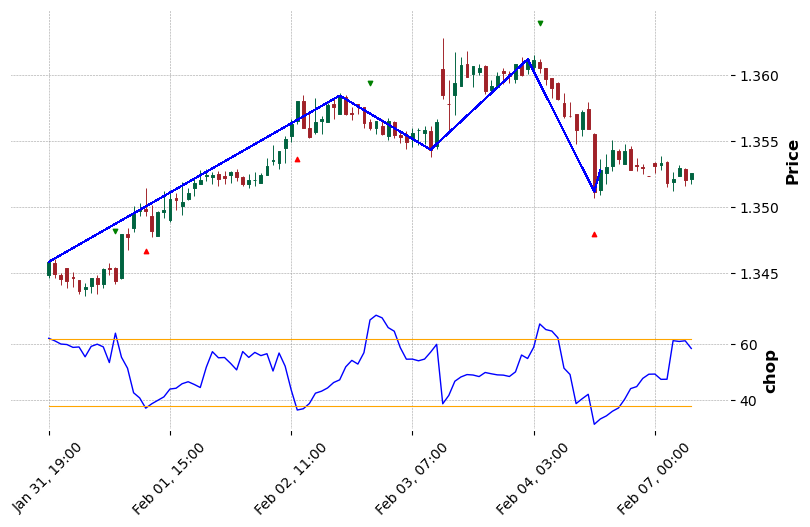

up end


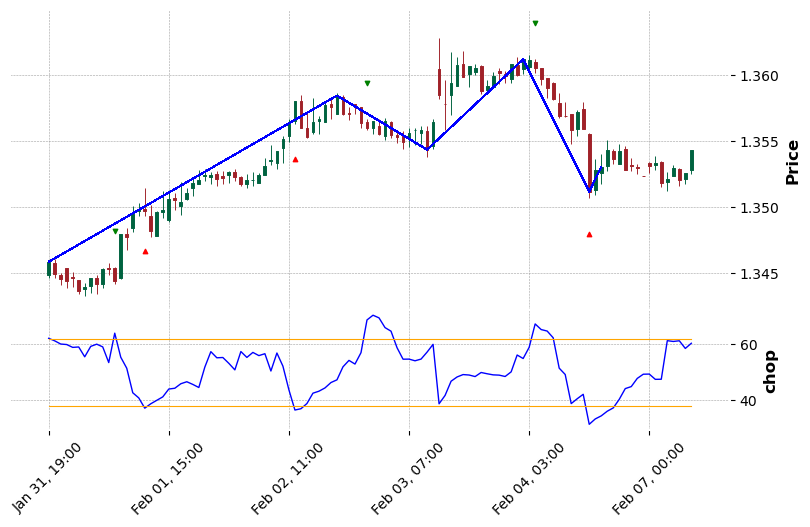

up end


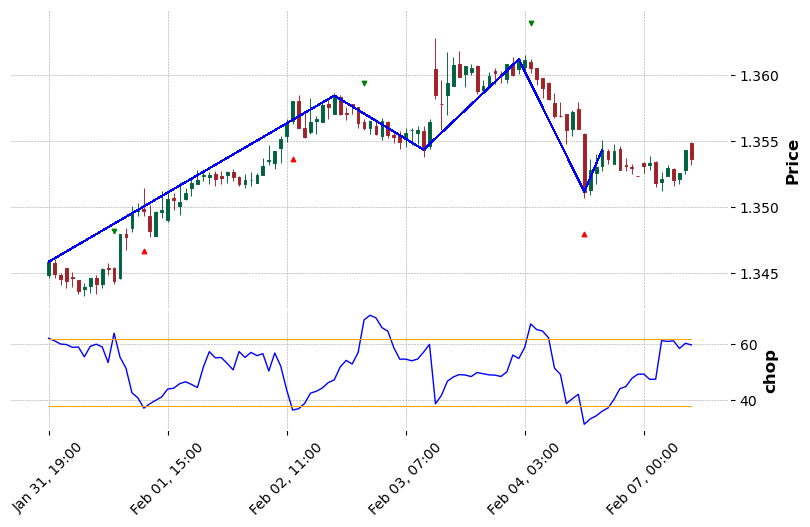

up end


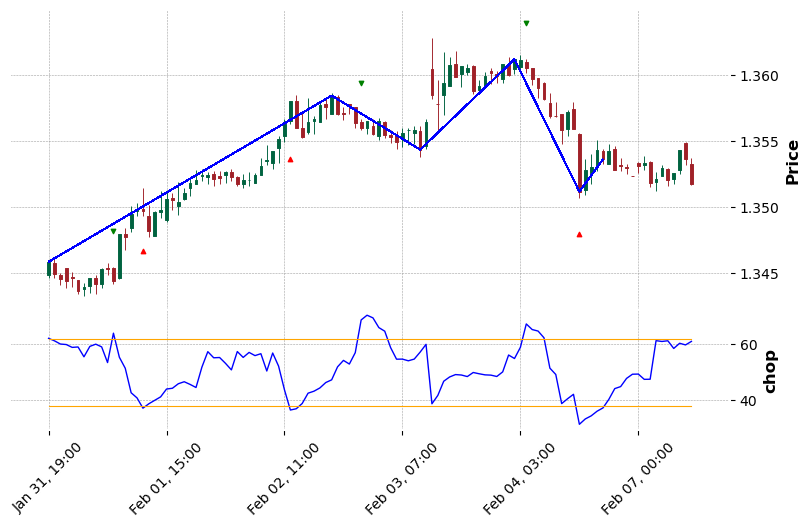

up end


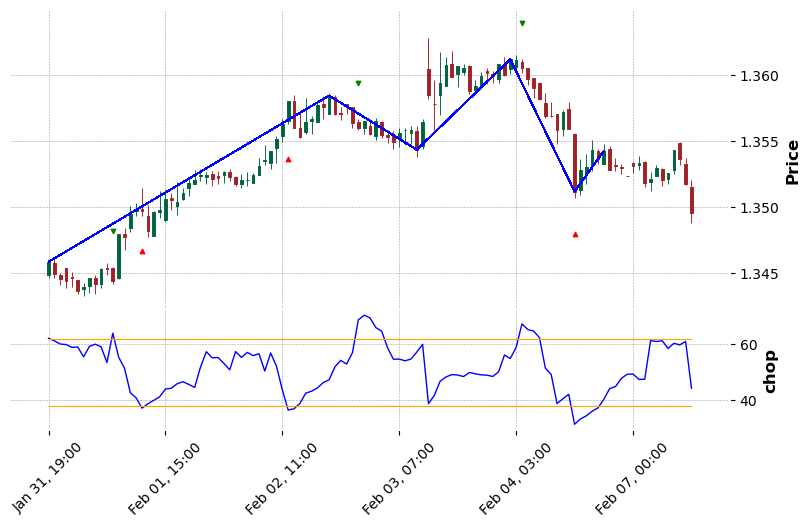

up end


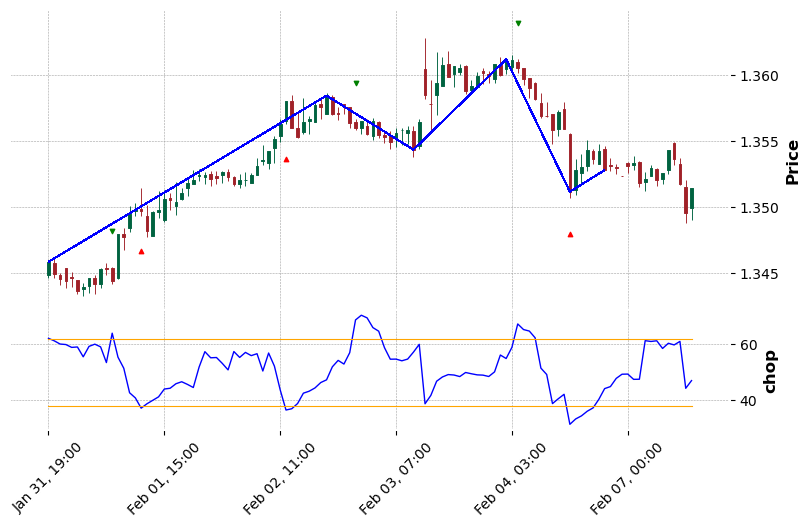

up end


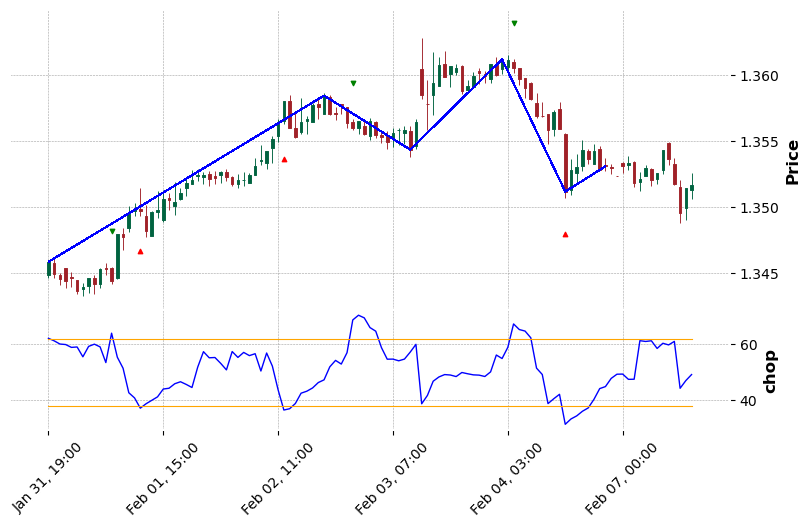

up end


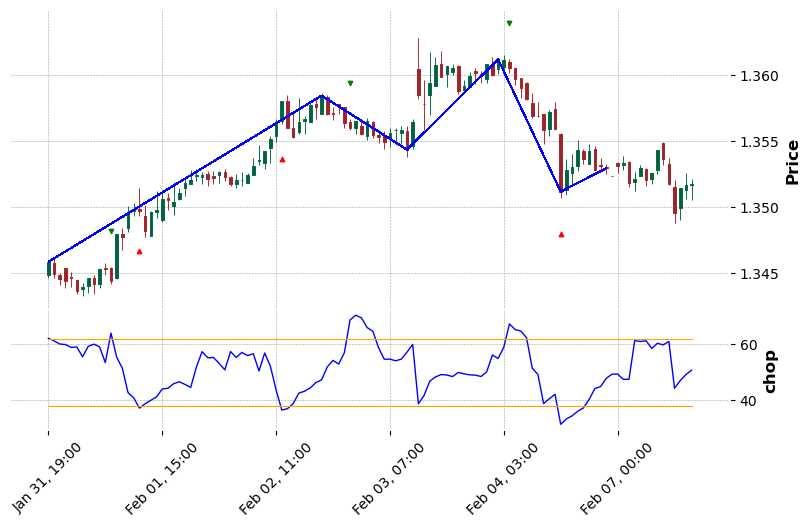

up end


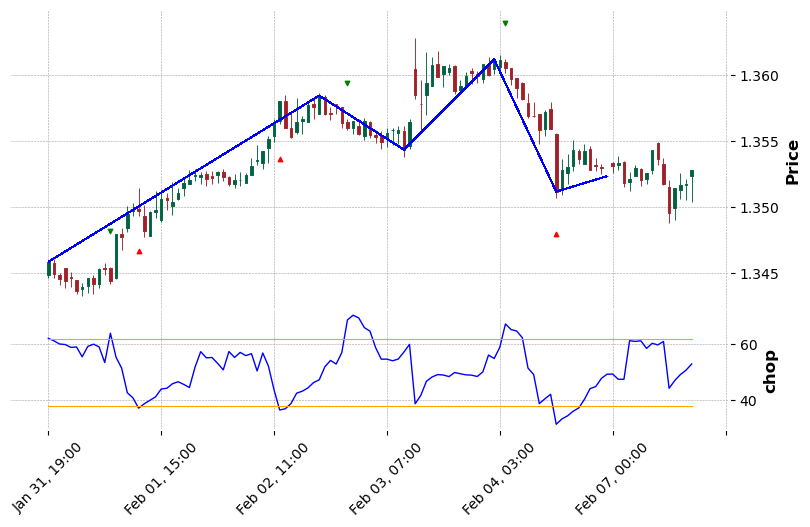

up end


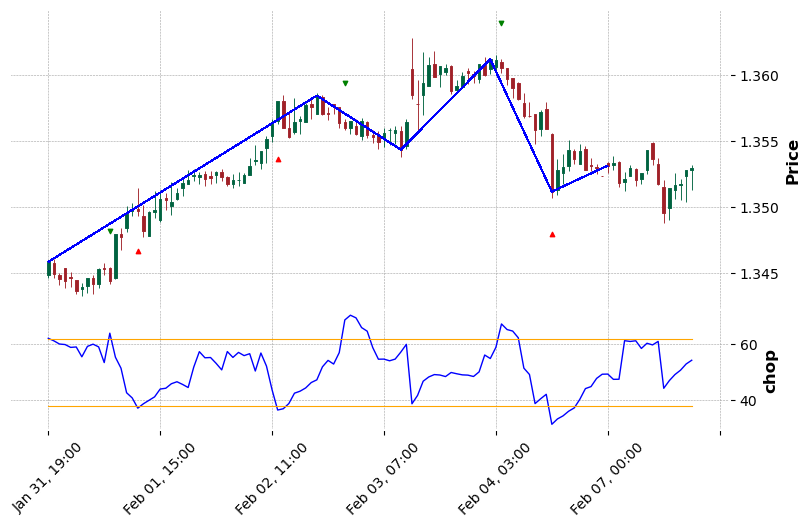

up end


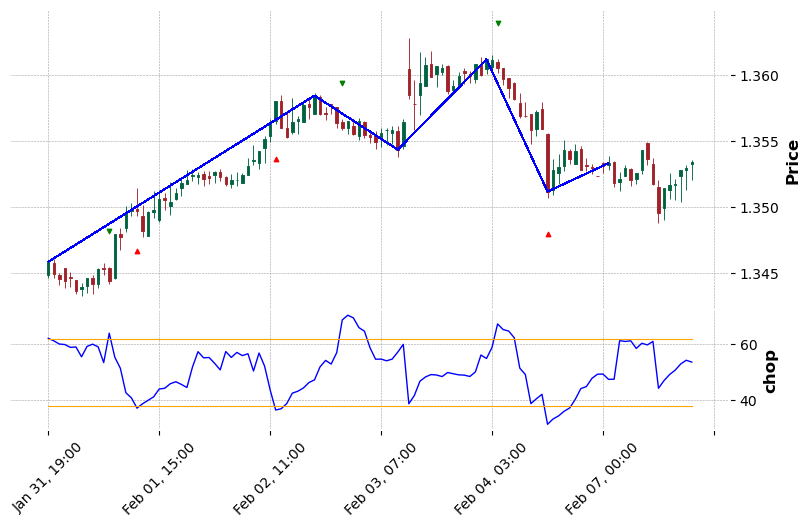

up end


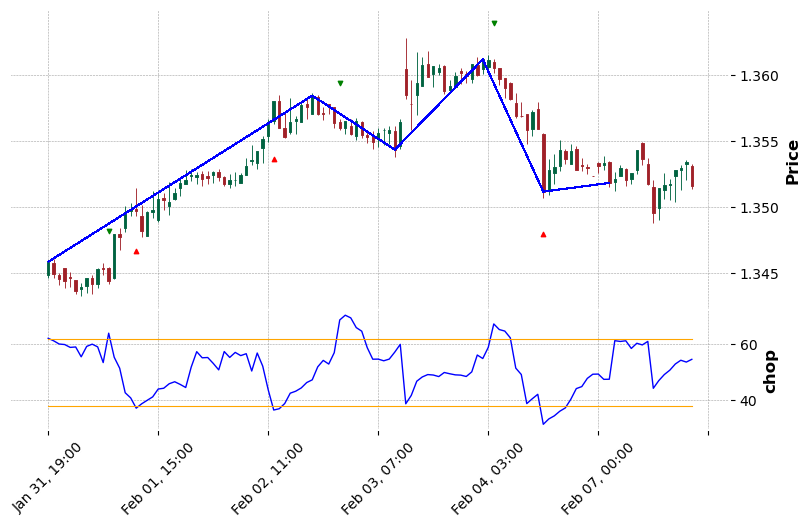

up end


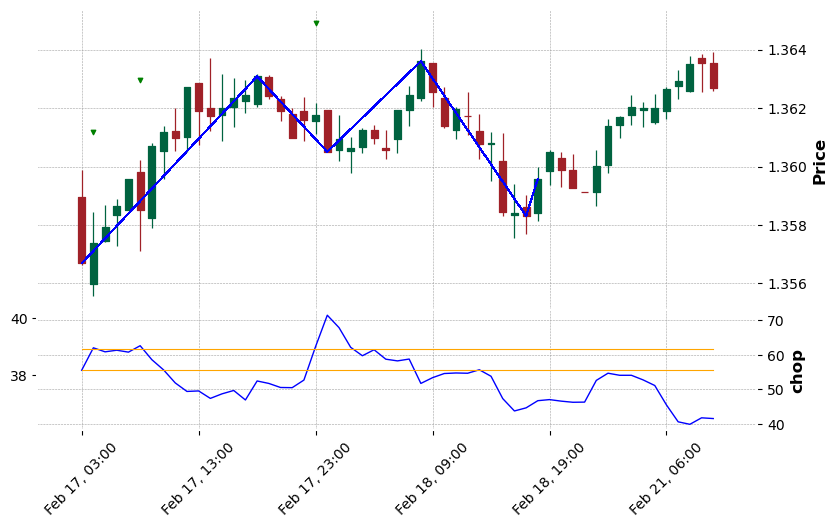

up end


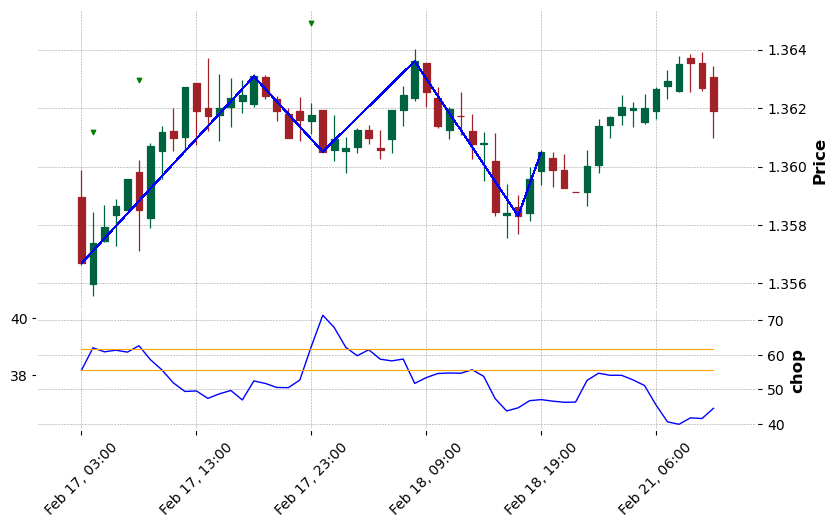

up end


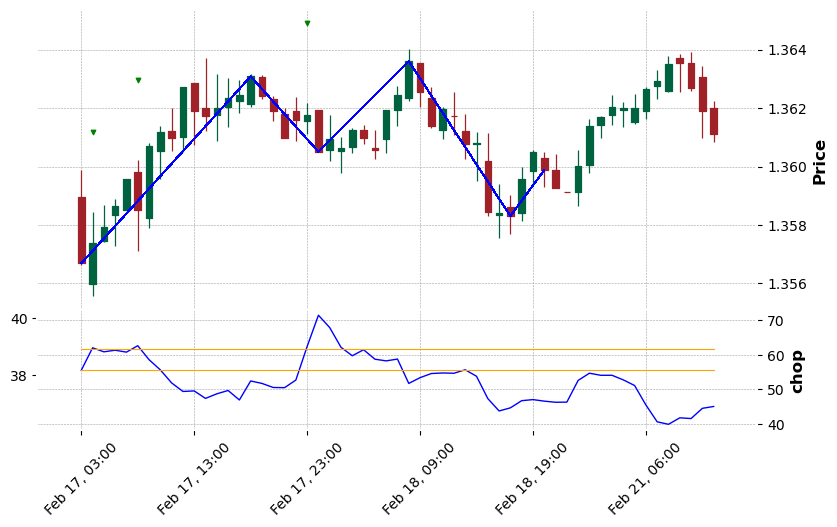

up end


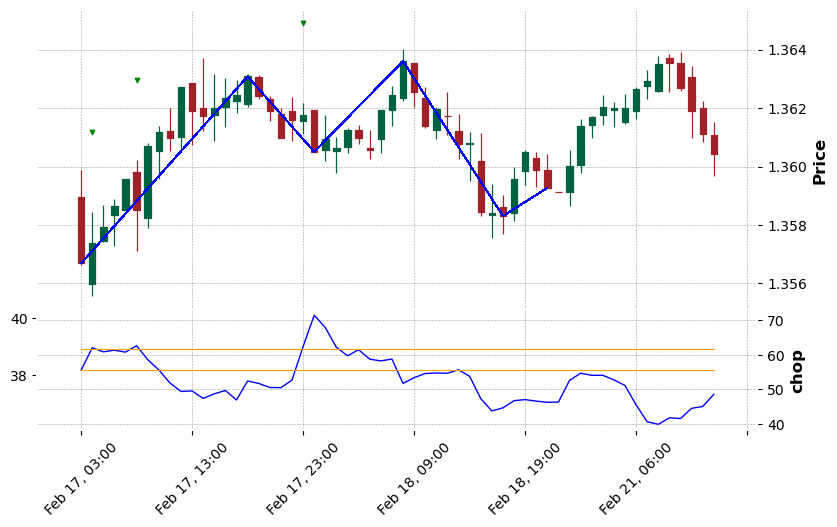

up end


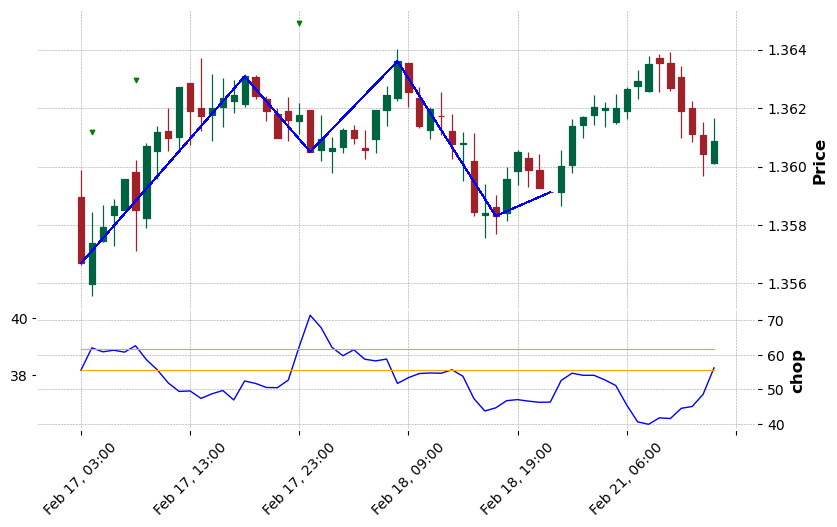

up end


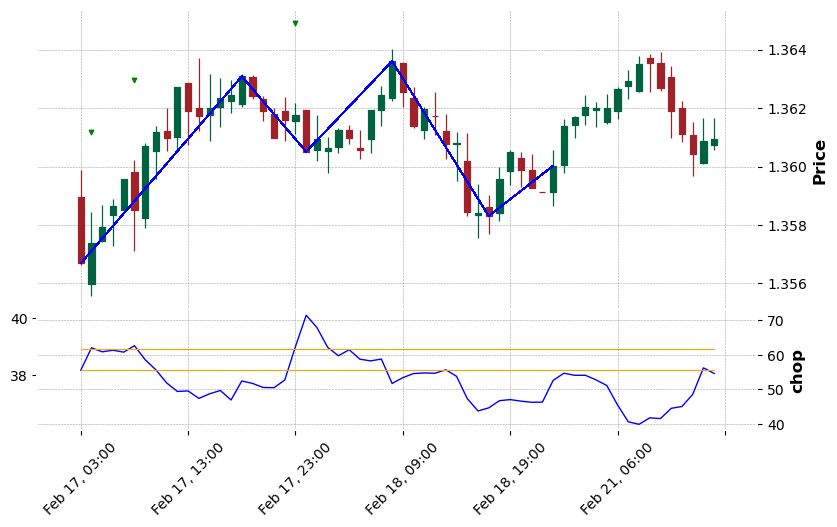

up end


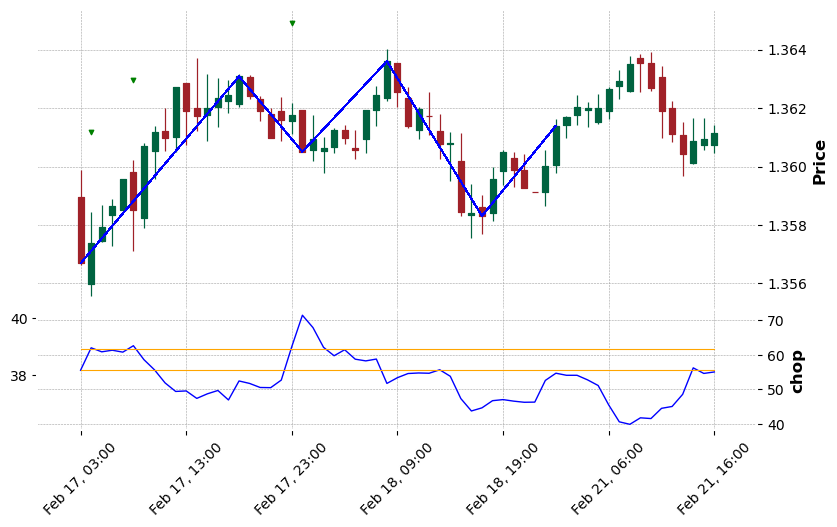

up end


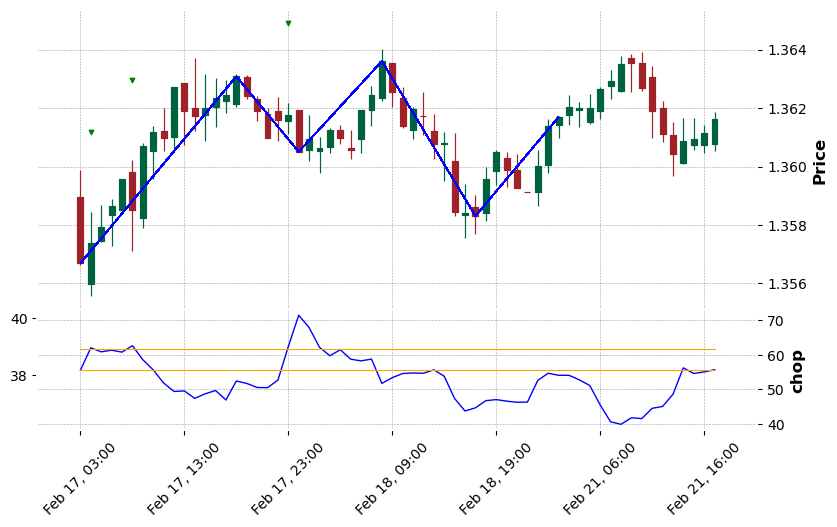

up end


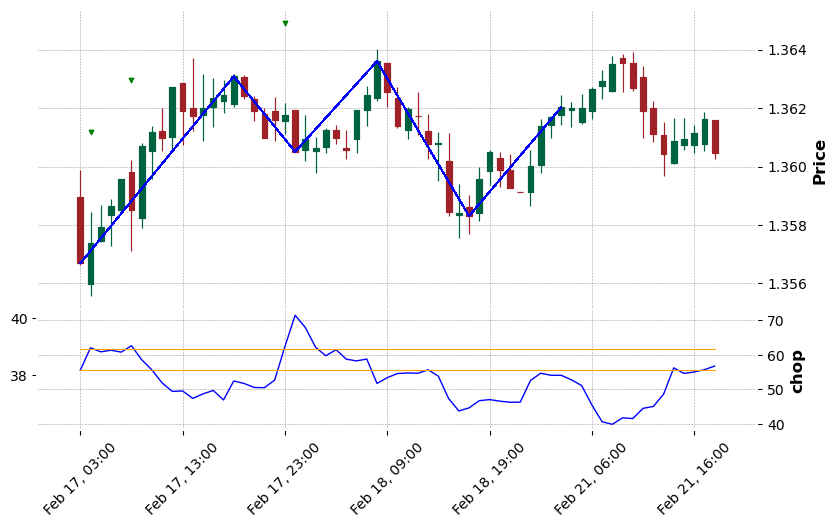

up end


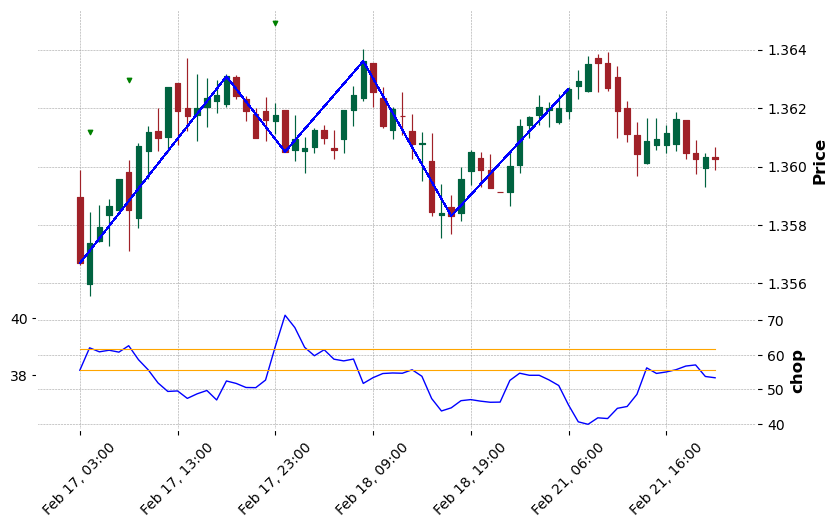

up end


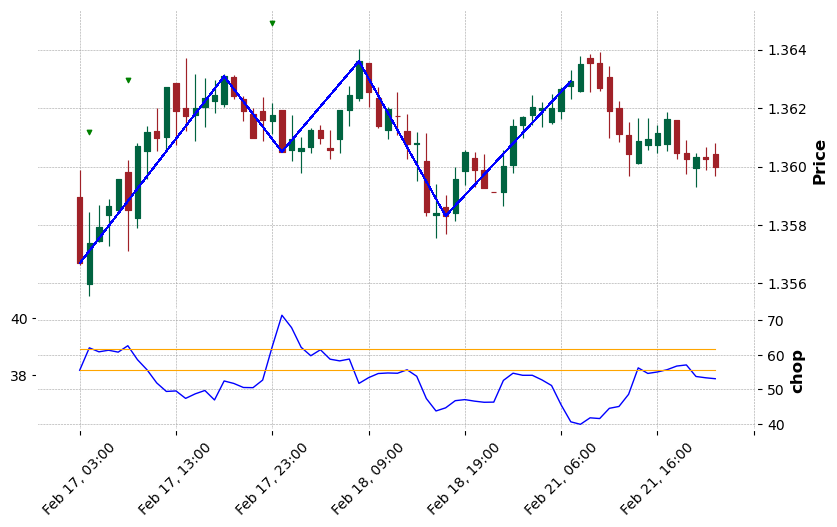

up end


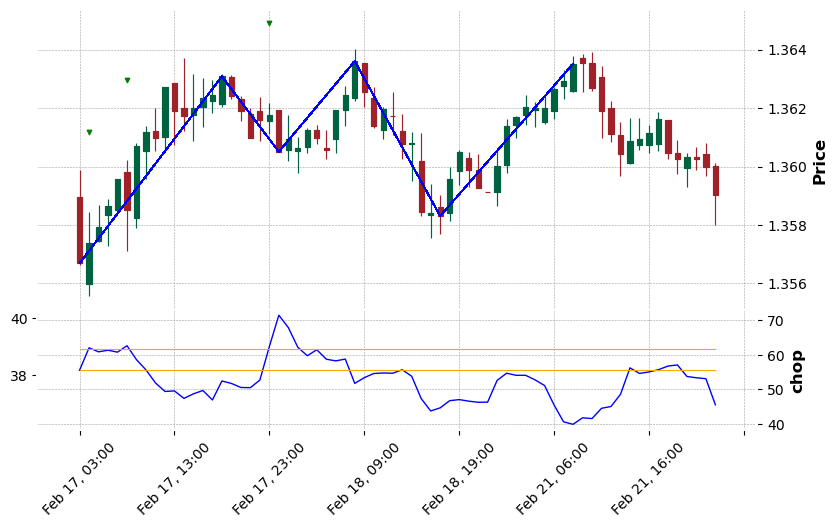

up end


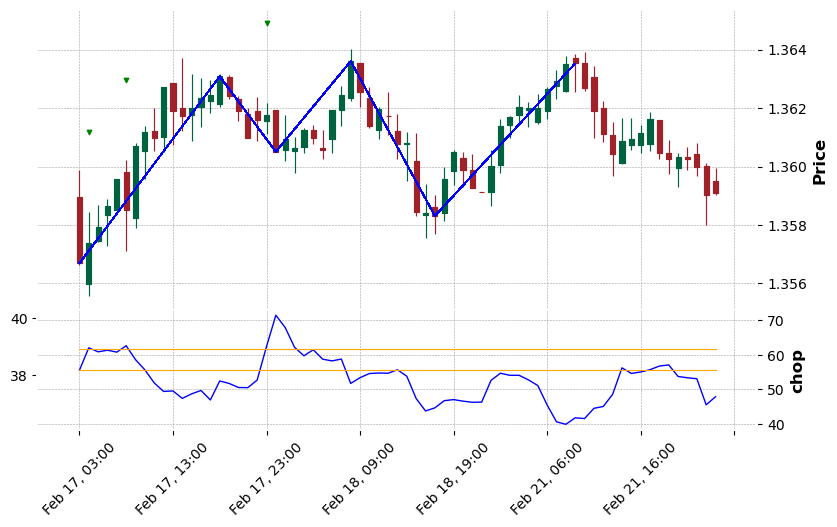

In [75]:
price = df['close'].copy()
for i in range(1500, 2000):
    
     current_pat, current_idx, start, end = find_peak(price, i, 10)
     peak_lines = [(price.index[current_idx[i]], current_pat[i]) for i in range(len(current_pat))]
     trend = find_trend(current_pat) # , err_allowed)
     # print(current_pat)
    
     if trend == 'up end': #is not False:
          print(trend)
          mpf.plot(df.iloc[start:i+15], type='candle', style='charles',
               addplot=chop_plot(df, start, i+15, 14),
               alines=dict(alines=peak_lines,colors=['blue'], linewidths=0.8),
               figsize=(10, 6))

In [ ]:
# ดูว่าก่อนและหลังจากค่ามากว่า 61.8 กราฟเป็นเทรนแบบไหน
# ดูว่าก่อนและหลังจากค่าน้อยกว่า 38.2 กราฟเป็นเทรนแบบไหน
df_index = 100
df_test = df.iloc[df_index:2000].copy()

for index, row in df_test.iterrows():
    chop_signal = ''
    if row['chop_below38'] == True or row['chop_above61'] == True:
        if row['chop_above61'] == True: chop_signal = 'above 61.8'
        if row['chop_below38'] == True: chop_signal = 'below 38.2'

        before_pat, before_idx, b_start, b_end = find_peak(df_test.close, df_index, 2)
        after_pat, after_idx, a_start, a_end = find_peak(df_test.close, df_index+50, 2)
        before_peak_lines = [(df_test.index[before_idx[i]], before_pat[i]) for i in range(len(before_pat))]
        after_peak_lines = [(df_test.index[after_idx[i]], after_pat[i]) for i in range(len(after_pat))]

        if len(before_pat) >= 5:
            trend = find_trend(before_pat)
            if trend != False:
                print(f'Before {chop_signal}: {trend}')
                mpf.plot(df_test.iloc[df_index-30: df_index+1], type='candle', style='charles',
                    addplot=chop_plot(df_test, df_index-30, df_index+1, 14),
                    alines=dict(alines=before_peak_lines,colors=['blue'], linewidths=0.8),
                    figsize=(10, 6))

        if len(after_pat) >= 5:
            trend = find_trend(after_pat)
            if trend != False:
                print(f'After {chop_signal}: {trend}')
                # mpf.plot(df_test.iloc[df_index: df_index+50], type='candle', style='charles',
                #     addplot=chop_plot(df_test, df_index, df_index+50, 14),
                #     alines=dict(alines=after_peak_lines,colors=['blue'], linewidths=0.8),
                #     figsize=(10, 6))

    df_index = df_index + 1

In [66]:
# ดูว่าก่อนและหลังจากค่ามากว่า 61.8 ไป 10 bars กราฟเคลื่อนที่ไปกี่ pips
# ดูว่าก่อนและหลังจากค่าน้อยกว่า 38.2 ไป 10 bars กราฟเคลื่อนที่ไปกี่ pips

df_index = 10
df_test = df.iloc[df_index:].copy()

b_pips_below38 = pd.DataFrame(columns=['pips', 'index_num', 'type'])
a_pips_below38 = pd.DataFrame(columns=['pips', 'index_num', 'type'])
b_pips_above61 = pd.DataFrame(columns=['pips', 'index_num', 'type'])
a_pips_above61 = pd.DataFrame(columns=['pips', 'index_num', 'type'])

for index, row in df_test.iterrows():
    before_bars = df_test.iloc[df_index-10:df_index]
    after_bars = df_test.iloc[df_index: df_index+10]
    list_before = list(before_bars.close)
    list_after = list(after_bars.close)
    if len(list_after) < 10: break

    b_pips_min = abs(row['close'] - min(list_before))/0.0001
    b_pips_max = abs(row['close'] - max(list_before))/0.0001
    a_pips_min = abs(row['close'] - min(list_after))/0.0001
    a_pips_max = abs(row['close'] - max(list_after))/0.0001

    if row['chop_below38'] == True:

        if b_pips_min > b_pips_max:
            b_pips_below38 = b_pips_below38.append({'pips': b_pips_min, 'index_num': df_index, 'type':'down'}, ignore_index=True)
        elif b_pips_min < b_pips_max:
            b_pips_below38 = b_pips_below38.append({'pips': b_pips_max, 'index_num': df_index, 'type':'up'}, ignore_index=True)

        if a_pips_min > a_pips_max:
            a_pips_below38 = a_pips_below38.append({'pips': a_pips_min, 'index_num': df_index, 'type':'down'}, ignore_index=True)
        elif a_pips_min < a_pips_max:
            a_pips_below38 = a_pips_below38.append({'pips': a_pips_max, 'index_num': df_index, 'type':'up'}, ignore_index=True)

    elif row['chop_above61'] == True:

        if b_pips_min > b_pips_max:
            b_pips_above61 = b_pips_above61.append({'pips': b_pips_min, 'index_num': df_index, 'type':'down'}, ignore_index=True)
        elif b_pips_min < b_pips_max:
            b_pips_above61 = b_pips_above61.append({'pips': b_pips_max, 'index_num': df_index, 'type':'up'}, ignore_index=True)

        if a_pips_min > a_pips_max:
            a_pips_above61 = a_pips_above61.append({'pips': a_pips_min, 'index_num': df_index, 'type':'down'}, ignore_index=True)
        elif a_pips_min < a_pips_max:
            a_pips_above61 = a_pips_above61.append({'pips': a_pips_max, 'index_num': df_index, 'type':'up'}, ignore_index=True)

    df_index = df_index + 1

# print('before below38', b_pips_below38)
# print('after below38', a_pips_below38)
# print('before above61', b_pips_above61)
# print('after above61', a_pips_above61)

In [65]:
print(b_pips_below38['pips'].mean(),
    a_pips_below38['pips'].mean(),
    b_pips_above61['pips'].mean(),
    a_pips_above61['pips'].mean()
)

49.61194029850746 67.08955223880596 44.2625 58.68125


In [68]:
bar = vbt.plotting.Bar(
    data=[[int(b_pips_below38['pips'].mean()), int(a_pips_below38['pips'].mean())], 
        [int(b_pips_above61['pips'].mean()),  int(a_pips_above61['pips'].mean())]
        ],
    trace_names=['previous 10 bars', 'after 10 bars'],
    x_labels=['below 38.2: ', 'above 61.8: ']
)
bar.fig

FigureWidget({
    'data': [{'name': 'previous 10 bars',
              'showlegend': True,
              'type…

In [228]:
def custom_chop(open, high, low, close, 
                EMA_period = 30,
                chop_length = 14) :

    vbt_ema = vbt.IndicatorFactory.from_pandas_ta('ema')
    vbt_chop = vbt.IndicatorFactory.from_pandas_ta('chop')
    ema = vbt_ema.run(close, length=EMA_period)
    chop = vbt_chop.run(close=close, low=low, high=high, length=chop_length)

    chop_df = pd.DataFrame(data=chop.chop.values, columns=['CHOP_'+str(chop_length)], index=chop.chop.index)
    ema_df = pd.DataFrame(data=ema.ema.values, columns=['EMA_'+str(EMA_period)], index=ema.ema.index)
    _df = pd.concat([chop_df, ema_df], axis=1)

    _df['prev_chop_'+str(chop_length)] = _df['CHOP_'+str(chop_length)].shift(1)
    _df['chop_'+str(chop_length)+'_above61'] = (_df['prev_chop_'+str(chop_length)] < 61.8)&(_df['CHOP_'+str(chop_length)] >= 61.8)
    _df['chop_'+str(chop_length)+'_below38'] = (_df['prev_chop_'+str(chop_length)] > 38.2)&(_df['CHOP_'+str(chop_length)] <= 38.2)
    _df['chop_'+str(chop_length)+'_end61'] = (_df['prev_chop_'+str(chop_length)] >= 61.8)&(_df['CHOP_'+str(chop_length)] < 61.8)
    _df['chop_'+str(chop_length)+'_end38'] = (_df['prev_chop_'+str(chop_length)] <= 38.2)&(_df['CHOP_'+str(chop_length)] > 38.2)

    _df['entries'] = False
    _df['exits'] = False
    _df['short_entries'] = False
    _df['short_exits'] = False

    _df['low'] = low
    _df['high'] = high

    current_action = 'close'
    for index, row in _df.iterrows():
        if current_action == 'close':
            if (row['CHOP_'+str(chop_length)] < 50) and (row['low'] > row['EMA_'+str(EMA_period)]):
                _df.at[index, 'entries'] = True
                current_action = 'long'
                
            elif (row['CHOP_'+str(chop_length)] < 50) and (row['high'] < row['EMA_'+str(EMA_period)]):
                _df.at[index, 'short_entries'] = True
                current_action = 'short'
            
        elif current_action == 'long':
            if row['chop_'+str(chop_length)+'_end38'] == True:
                current_action = 'close'
                _df.at[index, 'exits'] = True
                    
        elif current_action == 'short':
            if row['chop_'+str(chop_length)+'_end38'] == True:
                current_action = 'close'
                _df.at[index, 'short_exits'] = True
    
    return _df['entries'], _df['exits'], _df['short_entries'], _df['short_exits']
    # return entries, exits

In [229]:
df_test = df.copy()
x, y, a, b = custom_chop(df_test.open, df_test.high, df_test.low, df_test.close, 100, 14)

In [230]:
b[b==True]

timestamp
2021-11-11 06:00:00    True
2021-11-19 13:00:00    True
2021-12-01 07:00:00    True
2021-12-08 12:00:00    True
2021-12-14 04:00:00    True
                       ... 
2022-08-21 23:00:00    True
2022-08-23 17:00:00    True
2022-08-24 02:00:00    True
2022-08-29 09:00:00    True
2022-08-30 15:00:00    True
Name: short_exits, Length: 79, dtype: bool

In [231]:
Chop_EMA = vbt.IndicatorFactory(class_name='Chop_EMA',
                                input_names=['open', 'high', 'low', 'close'],
                                param_names=['EMA_period', 'chop_length'],
                                output_names=['entries', 'exits', 'short_entries', 'short_exits'],
                               ).from_apply_func(custom_chop,
                                                 EMA_period=30,
                                                 chop_length=14)

In [249]:
df_test = df.copy()
result = Chop_EMA.run(df_test.open, df_test.high, df_test.low, df_test.close,
                 EMA_period=np.arange(15, 50),
                 chop_length=np.arange(5, 40),
                 param_product=True)

In [250]:
pf = vbt.Portfolio.from_signals(df_test['close'],
                                entries=result.entries, 
                                exits=result.exits,
                                short_entries=result.short_entries,
                                short_exits=result.short_exits,
                                fees=0.0002,
                                slippage=0.0002
                                )

In [251]:
comb_ret = pf.total_return()
pf.total_return()

chop_ema_EMA_period  chop_ema_chop_length
15                   5                      -0.259655
                     6                      -0.178853
                     7                      -0.141971
                     8                      -0.202374
                     9                      -0.094213
                                               ...   
49                   35                     -0.098171
                     36                     -0.109767
                     37                     -0.125479
                     38                     -0.104476
                     39                     -0.120929
Name: total_return, Length: 1225, dtype: float64

In [252]:
pf.drawdown()

chop_ema_EMA_period         15                                          \
chop_ema_chop_length        5         6         7         8         9    
timestamp                                                                
2021-11-04 17:00:00   0.000000  0.000000  0.000000  0.000000  0.000000   
2021-11-04 18:00:00   0.000000  0.000000  0.000000  0.000000  0.000000   
2021-11-04 19:00:00   0.000000  0.000000  0.000000  0.000000  0.000000   
2021-11-04 20:00:00   0.000000  0.000000  0.000000  0.000000  0.000000   
2021-11-04 21:00:00   0.000000  0.000000  0.000000  0.000000  0.000000   
...                        ...       ...       ...       ...       ...   
2022-08-30 12:00:00  -0.260417 -0.187136 -0.147222 -0.214305 -0.110959   
2022-08-30 13:00:00  -0.260417 -0.187136 -0.147222 -0.214305 -0.111052   
2022-08-30 14:00:00  -0.260712 -0.187461 -0.147563 -0.214619 -0.116356   
2022-08-30 15:00:00  -0.262448 -0.189368 -0.149222 -0.216148 -0.114636   
2022-08-30 16:00:00  -0.262743 -0.189693 -0.149564 -0.216148 -0.114636   

chop_ema_EMA_period                                                     ...  \
chop_ema_chop_length        10        11        12        13        14  ...   
timestamp                                                               ...   
2021-11-04 17:00:00   0.000000  0.000000  0.000000  0.000000  0.000000  ...   
2021-11-04 18:00:00   0.000000  0.000000  0.000000  0.000000  0.000000  ...   
2021-11-04 19:00:00   0.000000  0.000000  0.000000  0.000000  0.000000  ...   
2021-11-04 20:00:00   0.000000  0.000000  0.000000  0.000000  0.000000  ...   
2021-11-04 21:00:00   0.000000  0.000000  0.000000  0.000000  0.000000  ...   
...                        ...       ...       ...       ...       ...  ...   
2022-08-30 12:00:00  -0.140617 -0.178484 -0.145763 -0.209191 -0.155175  ...   
2022-08-30 13:00:00  -0.140708 -0.178571 -0.145853 -0.209274 -0.155264  ...   
2022-08-30 14:00:00  -0.145834 -0.183471 -0.150948 -0.213992 -0.160304  ...   
2022-08-30 15:00:00  -0.144514 -0.182210 -0.149636 -0.212777 -0.159006  ...   
2022-08-30 16:00:00  -0.144856 -0.182537 -0.149976 -0.213092 -0.159343  ...   

chop_ema_EMA_period         49                                          \
chop_ema_chop_length        30        31        32        33        34   
timestamp                                                                
2021-11-04 17:00:00   0.000000  0.000000  0.000000  0.000000  0.000000   
2021-11-04 18:00:00   0.000000  0.000000  0.000000  0.000000  0.000000   
2021-11-04 19:00:00   0.000000  0.000000  0.000000  0.000000  0.000000   
2021-11-04 20:00:00   0.000000  0.000000  0.000000  0.000000  0.000000   
2021-11-04 21:00:00   0.000000  0.000000  0.000000  0.000000  0.000000   
...                        ...       ...       ...       ...       ...   
2022-08-30 12:00:00  -0.069903 -0.068608 -0.111821 -0.091348 -0.126398   
2022-08-30 13:00:00  -0.069805 -0.068510 -0.111727 -0.091252 -0.126305   
2022-08-30 14:00:00  -0.064263 -0.062973 -0.106443 -0.085829 -0.121085   
2022-08-30 15:00:00  -0.066060 -0.064768 -0.108156 -0.087587 -0.122778   
2022-08-30 16:00:00  -0.066060 -0.064768 -0.108156 -0.087587 -0.122778   

chop_ema_EMA_period                                                    
chop_ema_chop_length        35        36        37        38       39  
timestamp                                                              
2021-11-04 17:00:00   0.000000  0.000000  0.000000  0.000000  0.00000  
2021-11-04 18:00:00   0.000000  0.000000  0.000000  0.000000  0.00000  
2021-11-04 19:00:00   0.000000  0.000000  0.000000  0.000000  0.00000  
2021-11-04 20:00:00   0.000000  0.000000  0.000000  0.000000  0.00000  
2021-11-04 21:00:00   0.000000  0.000000  0.000000  0.000000  0.00000  
...                        ...       ...       ...       ...      ...  
2022-08-30 12:00:00  -0.119615 -0.115975 -0.131576 -0.110715 -0.12446  
2022-08-30 13:00:00  -0.119522 -0.115882 -0.131485 -0.110621 -0.12446  
2022-08-30 14:00:00  -0.114

In [253]:
comb_ret.loc[comb_ret.values==comb_ret.max()]

chop_ema_EMA_period  chop_ema_chop_length
19                   30                      0.136721
Name: total_return, dtype: float64

In [254]:
fig = pf.total_return().vbt.heatmap(
    x_level='chop_ema_EMA_period', y_level='chop_ema_chop_length', symmetric=False,
    trace_kwargs=dict(colorbar=dict(title='Total return', tickformat='%')))
fig.show()

In [163]:
vbt_chop = vbt.IndicatorFactory.from_pandas_ta('chop')
vbt_ema = vbt.IndicatorFactory.from_pandas_ta('ema')
chop = vbt_chop.run(close=df_test.close, low=df_test.low, high=df_test.high, length=14, name='chop_14')
ema = vbt_ema.run(df_test.close, length=30)

In [173]:
# chop.chop
# ema.ema
c = pd.DataFrame(data=chop.chop.values, columns=['chop_14'], index=chop.chop.index)
e = pd.DataFrame(data=ema.ema.values, columns=['ema_30'], index=ema.ema.index)
d = pd.concat([c, e], axis=1)
d

,chop_14,ema_30
timestamp,,
2021-11-04 17:00:00,NaN,NaN
2021-11-04 18:00:00,NaN,NaN
2021-11-04 19:00:00,NaN,NaN
2021-11-04 20:00:00,NaN,NaN
2021-11-04 21:00:00,NaN,NaN
...,...,...
2022-08-30 12:00:00,54.761033,1.171654
2022-08-30 13:00:00,55.549325,1.171541
2022-08-30 14:00:00,37.924417,1.170985
